## Assignment 5 - Credit Card Fraud Detection with HBOS and ECOD methods

In [434]:
# Generate the data
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import seaborn as sns
import plotly
import plotly.express as px
import scipy.stats as stats
import plotly.io as pio
pio.renderers.default = "notebook"

## Feature Engineering

### Data Prep and Clean

In [435]:
df = pd.read_csv('purchase_credit_card.csv')

# change column names 
df.columns = ['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
      'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor', 'Transaction_Date',
      'Posted_Date', 'Merchant_Category']

In [436]:
#Creating separate Year and Month columns for future feature engineering
#Converting Transaction_Date and Posted_date from Python Object data type to datetime
df['Transaction_Date']=pd.to_datetime(df['Transaction_Date']) #the detail time are all at 12 am so no need to transform the detail time
df['Posted_Date']=pd.to_datetime(df['Posted_Date'])

#Convert Year_Month to date format
df['Year_Month'].dtype
df['Year_Month']=pd.to_datetime(df['Year_Month'], format='%Y%m')
df['Year'] = df['Year_Month'].dt.year
df['Month'] = df['Year_Month'].dt.month

#Creating 'Week_Number' from 'Transaction_Date'
df['Week_Number'] = df['Transaction_Date'].dt.isocalendar().week


#Creating 'Day_of_Week' from 'Transaction_Date'
day0fWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['Day_of_Week'] = df['Transaction_Date'].dt.dayofweek.map(day0fWeek)

df['Day_of_Week'].value_counts()

Wednesday    89644
Thursday     87537
Tuesday      86919
Friday       79917
Monday       61809
Saturday     26307
Sunday       10325
Name: Day_of_Week, dtype: int64

### Monetary Features

#### 1. agency_merchant_avg_ratio_amount

In [439]:
# 1.
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].mean()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['AVG_amount']

# add the new feature average spending to the dataset 
df1 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df1['agency_merchant_avg_ratio_amount'] = np.where(df1['AVG_amount']==0,0, df1['Amount'] / df1['AVG_amount'])

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df1[binned_var] = pd.qcut(df1[var],percentile)

df1[df1['agency_merchant_avg_ratio_amount']>2].sort_values('agency_merchant_avg_ratio_amount', ascending=False).head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,AVG_amount,agency_merchant_avg_ratio_amount,agency_merchant_avg_ratio_amount_D
147691,2013-08-01,63500,COMM. ON CONSUMER CREDIT,Todd,E,ROOM CHARGES,512.94,SHERATON DENVER,2013-08-07,2013-08-08,SHERATON,2013,8,32,Wednesday,0.187500,2735.680000,"(8.71, 2735.68]"
147648,2013-07-01,63500,COMM. ON CONSUMER CREDIT,Willson,M,ROOM CHARGES,170.98,SHERATON DENVER,2013-07-17,2013-07-18,SHERATON,2013,7,29,Wednesday,0.187500,911.893333,"(8.71, 2735.68]"
147634,2013-07-01,63500,COMM. ON CONSUMER CREDIT,Willson,M,ROOM CHARGES,170.98,SHERATON DENVER,2013-07-18,2013-07-19,SHERATON,2013,7,29,Thursday,0.187500,911.893333,"(8.71, 2735.68]"
147645,2013-07-01,63500,COMM. ON CONSUMER CREDIT,Willson,M,ROOM CHARGES,170.98,SHERATON DENVER,2013-07-17,2013-07-18,SHERATON,2013,7,29,Wednesday,0.187500,911.893333,"(8.71, 2735.68]"
285032,2014-02-01,2500,OKLAHOMA MILITARY DEPARTMENT,MCCALL,L,GENERAL PURCHASE,43296.00,SUNSHINE INDUSTRIES INC,2014-02-24,2014-02-25,"STATIONERY,OFFICE AND SCHOOL SUPPLY STORES",2014,2,9,Monday,149.098537,290.385144,"(8.71, 2735.68]"


#### 2. agency_merchant_median_ratio_amount

In [440]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['Median_amount']

# add the new feature median spending to the dataset 
df2 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
 
df2['agency_merchant_median_ratio_amount'] = np.where(df2['Median_amount']==0,0, df2['Amount'] / df2['Median_amount'])

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df2[binned_var] = pd.qcut(df2[var],percentile)

df2[df2['agency_merchant_median_ratio_amount']>2].sort_values('agency_merchant_median_ratio_amount', ascending=False).head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Median_amount,agency_merchant_median_ratio_amount,agency_merchant_median_ratio_amount_D
218925,2013-09-01,77000,UNIV. OF OKLA. HEALTH SCIENCES CENTER,77000,7,GENERAL PURCHASE,1903858.37,PAYMENT ADJUSTMENT,2013-08-21,2013-09-12,OTHER FEES,2013,9,34,Wednesday,3.605,528116.052705,"(28.085, 528116.053]"
212076,2013-08-01,77000,UNIV. OF OKLA. HEALTH SCIENCES CENTER,77000,7,GENERAL PURCHASE,1750379.98,PAYMENT ADJUSTMENT,2013-07-19,2013-08-05,OTHER FEES,2013,8,29,Friday,3.605,485542.296810,"(28.085, 528116.053]"
400124,2014-05-01,34500,DEPARTMENT OF TRANSPORTATION,Johnson,C,SALT PRODUCTS NMB,348053.75,NORTH AMERICAN SALT CO,2014-05-12,2014-05-13,CHEMICALS AND ALLIED PRODUCTS NOT ELSEWHERE CL...,2014,5,20,Monday,122.560,2839.864148,"(28.085, 528116.053]"
303482,2014-03-01,34500,DEPARTMENT OF TRANSPORTATION,Johnson,C,SALT PRODUCTS NMB,227438.75,NORTH AMERICAN SALT CO,2014-03-25,2014-03-26,CHEMICALS AND ALLIED PRODUCTS NOT ELSEWHERE CL...,2014,3,13,Tuesday,122.560,1855.733926,"(28.085, 528116.053]"
251488,2013-10-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,GENERAL PURCHASE,814934.76,EMC CORPORATION,2013-10-03,2013-10-07,"COMPUTERS, COMPUTER PERIPHERAL EQUIPMENT, SOFT...",2013,10,40,Thursday,468.990,1737.637817,"(28.085, 528116.053]"


#### 1. agency_merchant_avg_ratio_amount

In [441]:
# create average monthly spending group by agency and merchant category
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Month'])['Amount'].mean() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['AVG_amount']

# add the new feature average monthly spending to the dataset 
df3 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Month'])
df3['agency_merchant_month_avg_ratio_amount'] = np.where(df3['AVG_amount']==0,0, df3['Amount'] / df3['AVG_amount'])

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_month_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df3[binned_var] = pd.qcut(df3[var],percentile)

df3[df3['agency_merchant_month_avg_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,AVG_amount,agency_merchant_month_avg_ratio_amount,agency_merchant_month_avg_ratio_amount_D
16,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.0,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,235.679053,10.289417,"(8.05, 3.0596329968448308e+16]"
17,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.0,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,235.679053,10.289417,"(8.05, 3.0596329968448308e+16]"
33,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Gerlt,T,GENERAL PURCHASE,3582.0,TELVENT,2013-07-26,2013-07-29,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Friday,568.982548,6.295448,"(3.417, 8.05]"
47,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,DALCOUR,K,GENERAL PURCHASE,1312.2,NATURAL WATER COMPANY LLC,2013-07-24,2013-07-26,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Wednesday,568.982548,2.306222,"(1.34, 3.417]"
49,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,DALCOUR,K,GENERAL PURCHASE,914.0,AUTO-CHLOR SERVICES INC,2013-07-24,2013-07-26,CATALOG MERCHANTS,2013,7,30,Wednesday,450.829655,2.027373,"(1.34, 3.417]"


#### 4. agency_merchant_mon_median_ratio_amount

In [442]:
# create median monthly spending group by agency, merchant category
stat_by_mon4 = df.groupby(['Agency_Name', 'Merchant_Category', 'Month'])['Amount'].median() 
stat_by_mon4 = pd.DataFrame(stat_by_mon4)
stat_by_mon4.columns = ['Median_amount']

# add the new feature average monthly spending to the dataset 
df_mon4 = pd.merge(df, stat_by_mon4, how='left', on=['Agency_Name', 'Merchant_Category', 'Month'])
 
df_mon4['agency_merchant_mon_median_ratio_amount'] = np.where(df_mon4['Median_amount']==0,0, df_mon4['Amount'] / df_mon4['Median_amount'])
df_mon4['agency_merchant_mon_median_ratio_amount'].describe()

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_mon_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df_mon4[binned_var] = pd.qcut(df_mon4[var],percentile)
df_mon4[['agency_merchant_mon_median_ratio_amount_D']]

,agency_merchant_mon_median_ratio_amount_D
0,"(2.425, 8.71]"
1,"(0.389, 1.0]"
2,"(0.389, 1.0]"
3,"(2.425, 8.71]"
4,"(1.0, 2.425]"
...,...
442453,"(1.0, 2.425]"
442454,"(2.425, 8.71]"
442455,"(0.389, 1.0]"
442456,"(27.182, 598420.506]"


#### 5. agency_merchant_week_avg_ratio_amount

In [443]:
# create average weekly spending group by agency and merchant category
stat_by_mon5 = df.groupby(['Agency_Name', 'Merchant_Category', 'Week_Number'])['Amount'].mean() 
stat_by_mon5 = pd.DataFrame(stat_by_mon5)
stat_by_mon5.columns = ['AVG_amount']

# add the new feature average weekly spending to the dataset 
df_mon5 = pd.merge(df, stat_by_mon5, how='left', on=['Agency_Name', 'Merchant_Category', 'Week_Number'])

df_mon5['agency_merchant_week_avg_ratio_amount'] = np.where(df_mon5['AVG_amount']==0,0, df_mon5['Amount'] / df_mon5['AVG_amount'])
df_mon5['agency_merchant_week_avg_ratio_amount'].describe()

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_week_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df_mon5[binned_var] = pd.qcut(df_mon5[var],percentile)
df_mon5[['agency_merchant_week_avg_ratio_amount_D']]

,agency_merchant_week_avg_ratio_amount_D
0,"(1.351, 3.23]"
1,"(1.351, 3.23]"
2,"(0.184, 0.745]"
3,"(1.351, 3.23]"
4,"(0.184, 0.745]"
...,...
442453,"(0.745, 1.351]"
442454,"(1.351, 3.23]"
442455,"(0.029, 0.184]"
442456,"(3.23, 7.324]"


#### 6. agency_merchant_week_median_ratio_amount

In [444]:
# create median weekly spending group by agency and merchant category
stat_by_mon6 = df.groupby(['Agency_Name', 'Merchant_Category', 'Week_Number'])['Amount'].median() 
stat_by_mon6 = pd.DataFrame(stat_by_mon6)
stat_by_mon6.columns = ['Median_amount']

# add the new feature average weekly spending to the dataset 
df_mon6 = pd.merge(df, stat_by_mon6, how='left', on=['Agency_Name', 'Merchant_Category', 'Week_Number'])
 
df_mon6['agency_merchant_week_median_ratio_amount'] = np.where(df_mon6['Median_amount']==0,0, df_mon6['Amount'] / df_mon6['Median_amount'])
df_mon6['agency_merchant_week_median_ratio_amount'].describe()

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_week_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df_mon6[binned_var] = pd.qcut(df_mon6[var],percentile)
df_mon6[['agency_merchant_week_median_ratio_amount_D']]

,agency_merchant_week_median_ratio_amount_D
0,"(2.045, 7.78]"
1,"(1.0, 2.045]"
2,"(1.0, 2.045]"
3,"(2.045, 7.78]"
4,"(1.0, 2.045]"
...,...
442453,"(1.0, 2.045]"
442454,"(1.0, 2.045]"
442455,"(0.437, 1.0]"
442456,"(25.505, 235424.342]"


#### 7. agency_merchant_vendor_avg_ratio_amount

In [445]:
# create avg spending group by agency, merchant category, and vendor
stat_by_mon7 = df.groupby(['Agency_Name', 'Merchant_Category', 'Vendor'])['Amount'].mean() 
stat_by_mon7 = pd.DataFrame(stat_by_mon7)
stat_by_mon7.columns = ['AVG_amount']

# add the new feature average spending to the dataset 
df_mon7 = pd.merge(df, stat_by_mon7, how='left', on=['Agency_Name', 'Merchant_Category', 'Vendor'])
 
df_mon7['agency_merchant_vendor_avg_ratio_amount'] = np.where(df_mon7['AVG_amount']==0,0, df_mon7['Amount'] / df_mon7['AVG_amount'])
df_mon7['agency_merchant_vendor_avg_ratio_amount'].describe()

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_vendor_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df_mon7[binned_var] = pd.qcut(df_mon7[var],percentile)
df_mon7[['agency_merchant_vendor_avg_ratio_amount_D']]

,agency_merchant_vendor_avg_ratio_amount_D
0,"(1.22, 2.788]"
1,"(0.255, 0.958]"
2,"(1.22, 2.788]"
3,"(1.22, 2.788]"
4,"(0.255, 0.958]"
...,...
442453,"(0.04, 0.255]"
442454,"(1.22, 2.788]"
442455,"(1.22, 2.788]"
442456,"(6.116, 6.424384868444013e+16]"


#### 8. agency_merchant_vendor_median_ratio_amount

In [446]:
# create median spending group by agency, merchant category, and vendor
stat_by_mon8 = df.groupby(['Agency_Name', 'Merchant_Category', 'Vendor'])['Amount'].mean() 
stat_by_mon8 = pd.DataFrame(stat_by_mon8)
stat_by_mon8.columns = ['AVG_amount']

# add the new feature median spending to the dataset 
df_mon8 = pd.merge(df, stat_by_mon8, how='left', on=['Agency_Name', 'Merchant_Category', 'Vendor'])

df_mon8['agency_merchant_vendor_median_ratio_amount'] = np.where(df_mon8['AVG_amount']==0,0, df_mon8['Amount'] / df_mon8['AVG_amount'])
df_mon8['agency_merchant_vendor_median_ratio_amount'].describe()

#The values spread into a wide range
#cut by percentile for plotting
var = 'agency_merchant_vendor_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df_mon8[binned_var] = pd.qcut(df_mon8[var],percentile)
df_mon8[['agency_merchant_vendor_median_ratio_amount_D']]

,agency_merchant_vendor_median_ratio_amount_D
0,"(1.22, 2.788]"
1,"(0.255, 0.958]"
2,"(1.22, 2.788]"
3,"(1.22, 2.788]"
4,"(0.255, 0.958]"
...,...
442453,"(0.04, 0.255]"
442454,"(1.22, 2.788]"
442455,"(1.22, 2.788]"
442456,"(6.116, 6.424384868444013e+16]"


#### 9. Each cardholder's monthly transaction amount with 95% CI

In [447]:
# Sort the cardholder and transaction date
df_mon9 = df.sort_values(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])

# Calculate the difference in days between consecutive transaction dates for each cardholder
df_mon9['Amount_Diff'] = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])['Amount'].diff()

# Grouped by cardholder and calculate the normal distribution parameters
grouped_9 = df_mon9.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])['Amount']
mean = grouped_9.mean()
std = grouped_9.std()

# Create a DataFrame to store the results
stat_by_mon9 = pd.DataFrame({'Mean': mean,
                             'Std': std})
# add the new feature average spending to the dataset 
df_mon9 = df_mon9.merge(stat_by_mon9[['Mean', 'Std']], left_on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'], right_on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'], how='left')

df_mon9['upper_CI'] = np.where(df_mon9['Mean']==0, 0, df_mon9['Mean'] + 1.96*df_mon9['Std'])

#Filter out the consecutive transaction time passed is over 95% of the upper confidence interval
rec_outlier_mon9 = df_mon9[(df_mon9['Amount_Diff']>df_mon9['upper_CI']) & (df_mon9['upper_CI'] >= 0)]

#Plot the table of outlier
table_mon9 = pd.pivot_table(rec_outlier_mon9, values=['Amount_Diff', 'Mean', 'Std', 'upper_CI'], index=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])
table_mon9.head()

Amount_Diff       Mean  \
Cardholder_Last_Name Cardholder_First_Initial Month                           
24100                2                        3            35.30  -17.64000   
88000                8                        7           500.00    0.00000   
ACREE                T                        6          2955.21  425.76875   
                                              10          523.55  153.01000   
ADAMS                K                        9           624.96  171.13000   

                                                             Std     upper_CI  
Cardholder_Last_Name Cardholder_First_Initial Month                            
24100                2                        3        24.960869    31.283304  
88000                8                        7       353.553391     0.000000  
ACREE                T                        6      1058.273217  2499.984255  
                                              10      181.422280   508.597669  
ADAMS                K                        9       209.002225   580.774362

#### 10. Each cardholder's weekly transaction amount with 95% CI

In [448]:
# Sort the cardholder and Week
df_mon10 = df.sort_values(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'])

# Calculate the difference in days between consecutive transaction dates for each cardholder
df_mon10['Amount_Diff'] = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'])['Amount'].diff()

# Grouped by cardholder and calculate the normal distribution parameters
grouped_10 = df_mon10.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'])['Amount']
mean = grouped_10.mean()
std = grouped_10.std()


# Create a DataFrame to store the results
stat_by_mon10 = pd.DataFrame({'Mean': mean,
                             'Std': std})
# add the new feature average spending to the dataset 
df_mon10 = df_mon10.merge(stat_by_mon10[['Mean', 'Std']], left_on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'], right_on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'], how='left')

df_mon10['upper_CI'] = np.where(df_mon10['Mean']==0, 0, df_mon10['Mean'] + 1.96*df_mon10['Std'])

#Filter out the consecutive transaction time passed is over 95% of the upper confidence interval
rec_outlier_mon10 = df_mon10[(df_mon10['Amount_Diff']>df_mon10['upper_CI']) & (df_mon10['upper_CI'] >= 0)]

#Plot the table of outlier
table_mon10 = pd.pivot_table(rec_outlier_mon10, values=['Amount_Diff', 'Mean', 'Std', 'upper_CI'], index=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Week_Number'])
table_mon10.head()

,,,Amount_Diff,Mean,Std,upper_CI
Cardholder_Last_Name,Cardholder_First_Initial,Week_Number,,,,
24100,2,11,35.30,-17.640000,24.960869,31.283304
77000,7,19,0.16,0.000000,0.092376,0.000000
88000,8,28,500.00,0.000000,353.553391,0.000000
ADMIRE,A,15,798.25,179.041429,286.593988,740.765646
AGNELLI,M,12,1127.66,208.165000,370.273446,933.900954


#### 11. The ratio of each cardholder's daily amount to an average monthly amount


In [449]:
#grouped by Cardholder's last and first names and Month
stat_by_AllTrans = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])['Amount'].mean() 
stat_by_AllTrans = pd.DataFrame(stat_by_AllTrans)
stat_by_AllTrans.columns = ['AVG_amount']

# add the new feature average spending to the dataset 
df4 = pd.merge(df, stat_by_AllTrans, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Month'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df4['all_trans_month_avg_ratio_amount'] = np.where(df4['AVG_amount']==0,0, df4['Amount'] / df4['AVG_amount'])\

var = 'all_trans_month_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df4[binned_var] = pd.qcut(df4[var],percentile)

df4[df4['all_trans_month_avg_ratio_amount'] > 2].sort_values('all_trans_month_avg_ratio_amount', ascending=False).head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,AVG_amount,all_trans_month_avg_ratio_amount,all_trans_month_avg_ratio_amount_D
61186,2014-01-01,1000,OKLAHOMA STATE UNIVERSITY,Rash,C,GENERAL PURCHASE,-455.00,THE ATHERTON HOTL AT OSU,2014-01-27,2014-01-29,"LODGING--HOTELS,MOTELS,AND RESORTS",2014,1,5,Monday,-7.105427e-15,6.403556e+16,"(7.209, 6.403555720167424e+16]"
18338,2013-08-01,1000,OKLAHOMA STATE UNIVERSITY,Dady,L,GENERAL PURCHASE,2393.88,TARGET.COM,2013-08-22,2013-08-22,DISCOUNT STORES,2013,8,34,Thursday,1.515825e-13,1.579259e+16,"(7.209, 6.403555720167424e+16]"
61188,2014-01-01,1000,OKLAHOMA STATE UNIVERSITY,Rash,C,GENERAL PURCHASE,-53.15,THE ATHERTON HOTL AT OSU,2014-01-26,2014-01-29,"LODGING--HOTELS,MOTELS,AND RESORTS",2014,1,4,Sunday,-7.105427e-15,7.480198e+15,"(7.209, 6.403555720167424e+16]"
196135,2013-12-01,76000,UNIVERSITY OF OKLAHOMA,SHAHAN,K,GENERAL PURCHASE,-29.64,AMAZON MKTPLACE PMTS,2013-12-14,2013-12-16,BOOK STORES,2013,12,50,Saturday,-6.666667e-03,4.446000e+03,"(7.209, 6.403555720167424e+16]"
196898,2013-12-01,76000,UNIVERSITY OF OKLAHOMA,SHAHAN,K,GENERAL PURCHASE,-7.36,AMAZON MKTPLACE PMTS,2013-12-17,2013-12-18,BOOK STORES,2013,12,51,Tuesday,-6.666667e-03,1.104000e+03,"(7.209, 6.403555720167424e+16]"


#### 12. The ratio of each cardholder's daily amount to an average monthly amount with same agency, merchant category, and vendor

In [450]:
#grouped by Cardholder's last and first names and year
stat_by_mon10 = df.groupby(['Agency_Name', 'Merchant_Category', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Vendor', 'Month'])['Amount'].mean() 
stat_by_mon10 = pd.DataFrame(stat_by_mon10)
stat_by_mon10.columns = ['AVG_amount']
stat_by_mon10.head()

# add the new feature average spending to the dataset 
df10 = pd.merge(df, stat_by_mon10, how='left', on=['Agency_Name', 'Merchant_Category', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Vendor', 'Month'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df10['all_trans_mon12_avg_ratio_amount'] = np.where(df10['AVG_amount']==0,0, df10['Amount'] / df10['AVG_amount'])
df10['all_trans_mon12_avg_ratio_amount'].describe()

var = 'all_trans_mon12_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df10[binned_var] = pd.qcut(df10[var],percentile,duplicates='drop')
df10[['all_trans_mon12_avg_ratio_amount_D']]

,all_trans_mon12_avg_ratio_amount_D
0,"(0.699, 1.0]"
1,"(1.0, 2.016]"
2,"(0.699, 1.0]"
3,"(0.699, 1.0]"
4,"(0.699, 1.0]"
...,...
442453,"(0.101, 0.699]"
442454,"(0.101, 0.699]"
442455,"(1.0, 2.016]"
442456,"(0.699, 1.0]"


### Frequency Features

#### 1. Each cardholder's monthly transaction frequency with the same merchant category

In [451]:
#grouped by Cardholder's last and first names, merchant category, and month; then calculate the monthly freq
stat_by_freq1 = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category', 'Month']).size().reset_index(name='Count')
stat_by_freq1 = pd.DataFrame(stat_by_freq1)

#stat_by_freq1 = stat_by_freq1.drop(['Average_Count'], axis=1)
stat_by_freq1['Sum_Count'] = stat_by_freq1.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category'])['Count'].transform('sum')

# add the new feature average spending to the dataset 
df5 = pd.merge(df, stat_by_freq1, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category', 'Month'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df5['freq1'] = np.where(df5['Count']==0,0, df5['Count'] / df5['Sum_Count'])

df5 = df5.sort_values('freq1', ascending=False)
df5 = df5[df5['freq1'] != 1]
df5.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Count,Sum_Count,freq1
78645,2013-07-01,13100,DEPARTMENT OF CORRECTIONS,Chandler,S,SOL .9NACL 1000ML DRUG CS,43.50,MCKESSON MEDICAL SUPPLY,2013-07-24,2013-07-25,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,7,30,Wednesday,91,92,0.98913
80577,2013-07-01,13100,DEPARTMENT OF CORRECTIONS,Chandler,S,GENERAL PURCHASE,-87.75,MCKESSON MEDICAL SUPPLY,2013-07-26,2013-07-31,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,7,30,Friday,91,92,0.98913
78552,2013-07-01,13100,DEPARTMENT OF CORRECTIONS,Chandler,S,OVERLAY 35X72X31/2'' FMCV EA,139.92,MCKESSON MEDICAL SUPPLY,2013-07-18,2013-07-19,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,7,29,Thursday,91,92,0.98913
78551,2013-07-01,13100,DEPARTMENT OF CORRECTIONS,Chandler,S,LANCETS TECHLITE 100S 25G BX,7.65,MCKESSON MEDICAL SUPPLY,2013-07-18,2013-07-19,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,7,29,Thursday,91,92,0.98913
78646,2013-07-01,13100,DEPARTMENT OF CORRECTIONS,Chandler,S,TIP OTOSCOPE DISP 4MM BX,26.19,MCKESSON MEDICAL SUPPLY,2013-07-24,2013-07-25,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,7,30,Wednesday,91,92,0.98913


#### 2. Each cardholder's monthly transaction frequency with the same merchant category and agency

In [452]:
#grouped by Agency_Name, Cardholder's last and first names, merchant category, and Month; then calculate the monthly freq
stat_by_freq2 = df.groupby(['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category', 'Month']).size().reset_index(name='Count')
stat_by_freq2 = pd.DataFrame(stat_by_freq2)

#stat_by_freq2 = stat_by_freq2.drop(['Average_Count'], axis=1)
stat_by_freq2['Sum_Count'] = stat_by_freq2.groupby(['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category'])['Count'].transform('sum')

# add the new feature monthly frequency ratio of the number of transaction to the dataset 
df_freq2 = pd.merge(df, stat_by_freq2, how='left', on=['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Merchant_Category', 'Month'])

df_freq2['freq2'] = np.where(df_freq2['Count']==0,0, df_freq2['Count'] / df_freq2['Sum_Count'])

df_freq2 = df_freq2.sort_values('freq2', ascending=False)
df_freq2 = df_freq2[df_freq2['freq2'] != 1]

#### 3. Each cardholder's monthly transaction frequency with the same merchant category , agency, and vendor

In [453]:
#grouped by Agency_Name, Cardholder's last and first names, merchant category, vendor, and Month; then calculate the monthly frequency
stat_by_freq3 = df.groupby(['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Vendor', 'Merchant_Category', 'Month']).size().reset_index(name='Count')
stat_by_freq3 = pd.DataFrame(stat_by_freq3)

stat_by_freq3['Sum_Count'] = stat_by_freq3.groupby(['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Vendor', 'Merchant_Category'])['Count'].transform('sum')

df_freq3 = pd.merge(df, stat_by_freq3, how='left', on=['Agency_Name', 'Cardholder_Last_Name', 'Cardholder_First_Initial', 'Vendor', 'Merchant_Category', 'Month'])

df_freq3['freq3'] = np.where(df_freq3['Count']==0,0, df_freq3['Count'] / df_freq3['Sum_Count'])

df_freq3 = df_freq3.sort_values('freq3', ascending=False)
df_freq3 = df_freq3[df_freq3['freq3'] != 1]
df_freq3.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Count,Sum_Count,freq3
81941,2013-08-01,13100,DEPARTMENT OF CORRECTIONS,Hawkins,S,SYR/NDL SFTY 3CC 22GX1.5' BX|SLEEVE KNEE 8'' M...,880.94,MCKESSON MEDICAL SUPPLY,2013-08-03,2013-08-05,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,8,31,Saturday,33,34,0.970588
81831,2013-08-01,13100,DEPARTMENT OF CORRECTIONS,Hawkins,S,TAPE PAPER 3''X10YD BX|TRAY WOUND CARE W/NW TW...,222.55,MCKESSON MEDICAL SUPPLY,2013-08-03,2013-08-05,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,8,31,Saturday,33,34,0.970588
81945,2013-08-01,13100,DEPARTMENT OF CORRECTIONS,Hawkins,S,CATH IV VNSHPT 18GX1 1/4' BX,90.48,MCKESSON MEDICAL SUPPLY,2013-08-04,2013-08-05,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,8,31,Sunday,33,34,0.970588
81180,2013-08-01,13100,DEPARTMENT OF CORRECTIONS,Hawkins,S,GENERAL PURCHASE,58.40,MCKESSON MEDICAL SUPPLY,2013-08-09,2013-08-12,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,8,32,Friday,33,34,0.970588
81946,2013-08-01,13100,DEPARTMENT OF CORRECTIONS,Hawkins,S,SUPPORT ANKLE LG EA|MACHINE SUCTION HVY DUTY E...,191.19,MCKESSON MEDICAL SUPPLY,2013-08-03,2013-08-05,DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP...,2013,8,31,Saturday,33,34,0.970588


### Recency Features

#### 1. The periodic normal contribution of consecutive transaction from each cardholder

In [454]:
import scipy.stats as stats
# Firstly sort the cardholder and transaction date
df_rec1 = df.sort_values(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Transaction_Date'])

# Calculate the difference in days between consecutive transaction dates for each cardholder
df_rec1['Days_Diff'] = df_rec1.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial'])['Transaction_Date'].diff().dt.days

# Grouped by cardholder and calculate the normal distribution parameters
grouped = df_rec1.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial'])['Days_Diff']
mean = grouped.mean()
std = grouped.std()


# Create a DataFrame to store the results
stat_by_rec1 = pd.DataFrame({'Mean': mean,
                             'Std': std})

# add the new feature average spending to the dataset 
df_rec1 = df_rec1.merge(stat_by_rec1[['Mean', 'Std']], left_on=['Cardholder_Last_Name', 'Cardholder_First_Initial'], right_on=['Cardholder_Last_Name', 'Cardholder_First_Initial'], how='left')

df_rec1['upper_CI'] = np.where(df_rec1['Mean']==0, 0, df_rec1['Mean'] + 1.96*df_rec1['Std'])

#Filter out the consecutive transaction time passed is over 95% of the upper confidence interval
rec_outlier = df_rec1[(df_rec1['Days_Diff']>df_rec1['upper_CI']) & (df_mon9['upper_CI'] >= 0)] 

#Plot the table of outlier
table_rec1 = pd.pivot_table(rec_outlier, values=['Days_Diff', 'Mean', 'Std', 'upper_CI'], index=['Cardholder_Last_Name', 'Cardholder_First_Initial'])
table_rec1.head()

,,Days_Diff,Mean,Std,upper_CI
Cardholder_Last_Name,Cardholder_First_Initial,,,,
24100,2,91.000000,26.888889,28.924231,83.580381
42000,4,103.000000,22.333333,23.011384,67.435647
48000,4,66.000000,17.750000,19.273746,55.526542
ACREE,T,25.666667,4.200000,6.111659,16.178852
ADAMS,C,52.500000,12.590909,16.769187,45.458515


## Merge the features & Cross Validation
The features are merged with similar characteristics and since HBOS and ECOD could not work with NaN values so I drop the na.

#### Avg/Median Ratio

In [484]:
feature_ratio = pd.concat([df1['agency_merchant_avg_ratio_amount'], df3['agency_merchant_month_avg_ratio_amount'], df_mon5['agency_merchant_week_avg_ratio_amount'], 
 df_mon7['agency_merchant_vendor_avg_ratio_amount'], df4['all_trans_month_avg_ratio_amount'], 
 df10['all_trans_mon12_avg_ratio_amount'], df2['agency_merchant_median_ratio_amount'], df_mon4['agency_merchant_mon_median_ratio_amount'], df_mon6['agency_merchant_week_median_ratio_amount'],
    df_mon8['agency_merchant_vendor_median_ratio_amount']], axis=1).dropna() #axis = 1 concatenates the columns horizontally

from sklearn.model_selection import train_test_split

# Split the data into train and test sets
# due to its unsupervised machine learning so it does not have Y variable
r_train, r_test = train_test_split(feature_ratio, test_size=0.3, random_state=42)

print("Train set shape:", r_train.shape)
print("Test set shape:", r_test.shape)

Train set shape: (309720, 10)
Test set shape: (132738, 10)


#### Frequency Ratio

In [485]:
#freq ratio 
feature_freq = pd.concat([df5['freq1'], df_freq2['freq2'], df_freq3['freq3']], axis=1).dropna()

f_train, f_test = train_test_split(feature_freq, test_size=0.3, random_state=42)

print("Train set shape:", f_train.shape)
print("Test set shape:", f_test.shape)

Train set shape: (204226, 3)
Test set shape: (87526, 3)


#### Upper Confidence Interval

In [486]:
#95% confidence interval of amount transaction
feature_upper = pd.concat([df_mon9['upper_CI'], df_mon10['upper_CI'], df_rec1['upper_CI']], axis = 1).dropna()
feature_upper.columns = ['mon_tran_upper', 'week_tran_upper', 'recency_upper']

u_train, u_test = train_test_split(feature_upper, test_size=0.3, random_state=42)

print("Train set shape:", u_train.shape)
print("Test set shape:", u_test.shape)

Train set shape: (280686, 3)
Test set shape: (120294, 3)


## HBOS

Histogram-Based Outlier Score
- Assume independence of a variable
- Univariate histogram for each single feature of unsupervised machine learning model
- Numeric data is discretised into static bins of equal width and the categorical data is counted by the categories
- Distribution-based algo generates results faster

### Step 1: Model Development

Since if I use the whole dataset, the system needs to spend a few hours so I use 70% of dataset to test the optimal parameter so that it wouldnt waste so much time and the data still has its completeness.

#### Ratio Feature Hyperparameter

In [513]:
from sklearn.metrics import silhouette_score
from pyod.models.hbos import HBOS

best_score = 0
best_params = None

# Define the range of bins and contamination values to explore
bin_range = range(20, 100, 20)
contamination_range = [0.01, 0.05]

for n_bins in bin_range:
    for contamination in contamination_range:
        # Create an instance of HBOS with the current parameter values
        hbos_ratio = HBOS(n_bins=n_bins, contamination=contamination)
        
        # Fit the model on the training data
        hbos_ratio.fit(r_train)
        
        # Calculate the silhouette score on the training data
        train_scores = hbos_ratio.decision_function(r_train)
        silhouette = silhouette_score(train_scores.reshape(-1, 1), train_scores)
        
        # Check if the current combination of parameters has a higher silhouette score
        if silhouette > best_score:
            best_score = silhouette
            best_params = (n_bins, contamination)

# Print the best parameters and their corresponding silhouette score
print("Best Parameters: n_bins={}, contamination={}".format(best_params[0], best_params[1]))
print("Best Silhouette Score:", best_score)


Best Parameters: n_bins=80, contamination=0.01
Best Silhouette Score: 0.0006748030479142451


**The optimal parameters of ratio feature: n_bins=80, contamination=0.01 (with best Silhouette Score: 0.0006748030479142451)**

In [516]:
n_bins = 80
hbos_r = HBOS(n_bins=n_bins,contamination=0.01)
hbos_r.fit(r_train)

# Training data
r_train_scores = hbos_r.decision_function(r_train)
r_train_pred = hbos_r.predict(r_train)

# Test data
r_test_scores = hbos_r.decision_function(r_test)
r_test_pred = hbos_r.predict(r_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , hbos_r.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(r_train_pred))
print("The test data:", count_stat(r_test_pred))

The threshold for the defined comtanimation rate: 33.2036315272572
The training data: {0: 309628, 1: 92}
The test data: {0: 132699, 1: 39}


#### Frequency Feature Hyperparameter

In [514]:
from sklearn.metrics import silhouette_score

best_score = 0
best_params = None

# Define the range of bins and contamination values to explore
bin_range = range(20, 100, 20)
contamination_range = [0.01, 0.05]

for n_bins in bin_range:
    for contamination in contamination_range:
        # Create an instance of HBOS with the current parameter values
        hbos_ratio = HBOS(n_bins=n_bins, contamination=contamination)
        
        # Fit the model on the training data
        hbos_ratio.fit(f_train)
        
        # Calculate the silhouette score on the training data
        train_scores = hbos_ratio.decision_function(f_train)
        silhouette = silhouette_score(train_scores.reshape(-1, 1), train_scores)
        
        # Check if the current combination of parameters has a higher silhouette score
        if silhouette > best_score:
            best_score = silhouette
            best_params = (n_bins, contamination)

# Print the best parameters and their corresponding silhouette score
print("Best Parameters: n_bins={}, contamination={}".format(best_params[0], best_params[1]))
print("Best Silhouette Score:", best_score)

Best Parameters: n_bins=20, contamination=0.01
Best Silhouette Score: 0.999476070627638


**The optimal parameters of frequency feature: n_bins=20, contamination=0.01 (with best Silhouette Score: 0.999476070627638)**

In [517]:
n_bins = 20
hbos_f = HBOS(n_bins=n_bins,contamination=0.01)
hbos_f.fit(f_train)

# Training data
f_train_scores = hbos_f.decision_function(f_train)
f_train_pred = hbos_f.predict(f_train)

# Test data
f_test_scores = hbos_f.decision_function(f_test)
f_test_pred = hbos_f.predict(f_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , hbos_f.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(f_train_pred))
print("The test data:", count_stat(f_test_pred))

The threshold for the defined comtanimation rate: 6.423011243312651
The training data: {0: 202229, 1: 1997}
The test data: {0: 86636, 1: 890}


#### Upper Confidence Interval Feature Hyperparameter

In [515]:
from sklearn.metrics import silhouette_score

best_score = 0
best_params = None

# Define the range of bins and contamination values to explore
bin_range = range(20, 100, 20)
contamination_range = [0.01, 0.05]

for n_bins in bin_range:
    for contamination in contamination_range:
        # Create an instance of HBOS with the current parameter values
        hbos_ratio = HBOS(n_bins=n_bins, contamination=contamination)
        
        # Fit the model on the training data
        hbos_ratio.fit(u_train)
        
        # Calculate the silhouette score on the training data
        train_scores = hbos_ratio.decision_function(u_train)
        silhouette = silhouette_score(train_scores.reshape(-1, 1), train_scores)
        
        # Check if the current combination of parameters has a higher silhouette score
        if silhouette > best_score:
            best_score = silhouette
            best_params = (n_bins, contamination)

# Print the best parameters and their corresponding silhouette score
print("Best Parameters: n_bins={}, contamination={}".format(best_params[0], best_params[1]))
print("Best Silhouette Score:", best_score)

Best Parameters: n_bins=20, contamination=0.01
Best Silhouette Score: 0.9976343672288607


**The optimal parameters of upper confidence interval feature: n_bins=20, contamination=0.01 (with best Silhouette Score: 0.9976343672288607)**

In [518]:
n_bins = 20
hbos_u = HBOS(n_bins=n_bins,contamination=0.01)
hbos_u.fit(u_train)

# Training data
u_train_scores = hbos_u.decision_function(u_train)
u_train_pred = hbos_u.predict(u_train)

# Test data
u_test_scores = hbos_u.decision_function(u_test)
u_test_pred = hbos_u.predict(u_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , hbos_u.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(u_train_pred))
print("The test data:", count_stat(u_test_pred))

The threshold for the defined comtanimation rate: 9.956316523336303
The training data: {0: 278248, 1: 2438}
The test data: {0: 119219, 1: 1075}


### Step 2: Setting up a reasonble benchmark


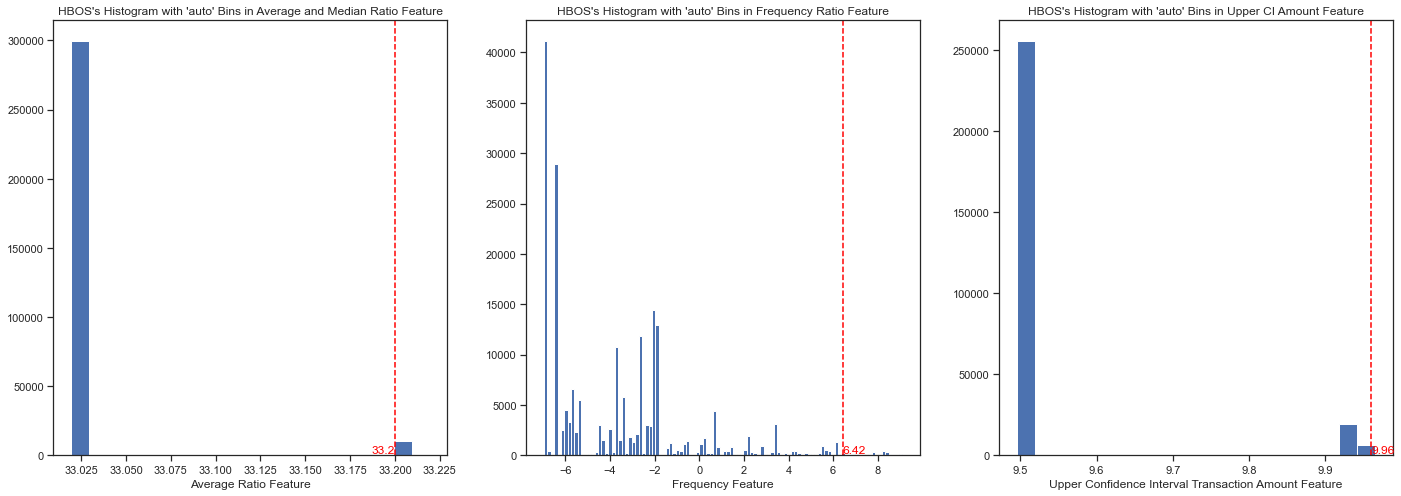

In [523]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

ax1.hist(r_train_scores, bins='auto')
ax1.set_title("HBOS's Histogram with 'auto' Bins in Average and Median Ratio Feature")
ax1.set_xlabel('Average Ratio Feature')
ax1.axvline(x=33.2, color='red', linestyle='--')
ax1.text(33.2, 0, "33.2", ha='right', va='bottom', color='red')

ax2.hist(f_train_scores, bins='auto')
ax2.set_title("HBOS's Histogram with 'auto' Bins in Frequency Ratio Feature")
ax2.set_xlabel('Frequency Feature')
ax2.axvline(x=6.42, color='red', linestyle='--')
ax2.text(6.42, 0, "6.42", ha='left', va='bottom', color='red')

ax3.hist(u_train_scores, bins='auto')
ax3.set_title("HBOS's Histogram with 'auto' Bins in Upper CI Amount Feature")
ax3.set_xlabel('Upper Confidence Interval Transaction Amount Feature')
ax3.axvline(x=9.96, color='red', linestyle='--')
ax3.text(9.96, 0, "9.96", ha='left', va='bottom', color='red')

plt.show()

Three figures above present the outlier scores. The histogram of ratio feature on the left, which the optimal threshold can be 33.2 and if the values are greater than this benchmark, they are outliers. Next, the histogram of frequency ratio in the middle has a suggested benchmark on 6.42 and the observations on the right of the red line are the outliers. The right-hand side graph is the histogram of upper confidence interval transaction amount feature, which the benchmark line is suggested as 9.96. The values that greater than 9.7 could be treated as outliers in this case.

### Step 3: Present the summary statistics of the normal and the abnormal groups
1. The size of the outlier group
2. The average anomaly score
3. The feature statistics in each group

In [525]:
# ratio feature
threshold = hbos_r.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)


descriptive_stat_threshold(r_train, r_train_scores, threshold)

,Group,Count,Count %,agency_merchant_avg_ratio_amount,agency_merchant_month_avg_ratio_amount,agency_merchant_week_avg_ratio_amount,agency_merchant_vendor_avg_ratio_amount,all_trans_month_avg_ratio_amount,all_trans_mon12_avg_ratio_amount,agency_merchant_median_ratio_amount,agency_merchant_mon_median_ratio_amount,agency_merchant_week_median_ratio_amount,agency_merchant_vendor_median_ratio_amount,Anomaly_Score
0,Normal,299553,96.717358,1.05,1.050000e+00,3.288844e+12,5.768964e+11,5.272053e+10,-2.261251e+11,2.75,2.49,2.39,5.768964e+11,33.02
1,Outlier,10167,3.282642,-0.50,-6.018753e+11,-3.160084e+13,-1.215517e+13,7.034106e+12,7.940889e+12,99.51,110.61,46.02,-1.215517e+13,33.20


The outliers of the ratio feature occupy roughly 3.3% of the dataset with significantly high anomaly score 33.2, which means the observation within a dataset deviates greatly from the expected pattern

In [529]:
# freq feature
threshold = hbos_f.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(f_train,f_train_scores, threshold)

,Group,Count,Count %,freq1,freq2,freq3,Anomaly_Score
0,Normal,202182,98.999148,0.19,0.19,0.25,-3.84
1,Outlier,2044,1.000852,0.77,0.78,0.83,7.84


The outliers of frequency feature occupy only 1% of the dataset with anomaly score 7.8, which shows that the observations here are highly unusual compared to the rest of the dataset.

In [530]:
# upper feature
threshold = hbos_u.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(u_train,u_train_scores, threshold)

,Group,Count,Count %,mon_tran_upper,week_tran_upper,recency_upper,Anomaly_Score
0,Normal,274435,97.772956,1980.55,1702.99,8.78,9.53
1,Outlier,6251,2.227044,863.64,766.93,78.45,9.96


The outliers of upper confidence interval feature occupy 2.2% of the dataset with anomaly score 10, which also shows that the observations deviate from the pattern established by the majority of the data points.

## ECOD

Empirical Cumulative Distribution-Based Hyperparameter Tuning
- Assume independence of variables
- Work with large and high-dimensional datasets or location based on unsupervised machine learning
- Estimate the distribution of data in a nonparameter fashion by computing cumulative distribution of dimension (e.g., tail probabilities)
- Aggregate tail probabilities across dimensions
- Since no hyperparameter in it, the model does not test a range of parameters so this model is fast to work with

### Step 1: Model Development

In [465]:
from numpy import hstack
from statsmodels.distributions.empirical_distribution import ECDF
from pyod.models.ecod import ECOD

In [466]:
#previous dataframe has HBOS Group and Anomaly values included so I need to clean the dataset by dropping those values
datasets = [feature_ratio, feature_ratio, feature_freq, feature_upper]

for dataset in datasets:
    if 'Group' in dataset.columns:
        dataset.drop('Group', axis=1, inplace=True)
    if 'Anomaly_Score' in dataset.columns:
        dataset.drop('Anomaly_Score', axis=1, inplace=True)

#### Average and Median Ratio Feature
It has 427,839 normal data and 14,619 outliers which the outliers are determined by threshold 33.57.

In [467]:
# feature_ratio data
ecod_ratio = ECOD(contamination=0.05)
ecod_ratio.fit(feature_ratio)
ratio_scores = ecod_ratio.decision_function(feature_ratio)
ratio_pred = ecod_ratio.predict(feature_ratio)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The feature of average ratio data:", count_stat(ratio_pred)) #0: Normal/1: Outlier

# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , ecod_ratio.threshold_)

The feature of average ratio data: {0: 420335, 1: 22123}
The threshold for the defined comtanimation rate: 33.56777567458843


In [468]:
#retrieve the index of outliers
np.where(ratio_scores>33.57)

(array([    16,     17,     25, ..., 442443, 442449, 442456], dtype=int64),)

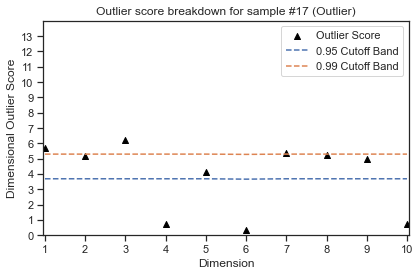

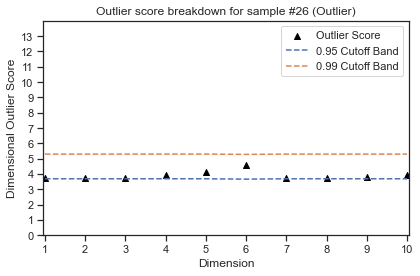

In [469]:
#plot the outliers
ecod_ratio.explain_outlier(16)
ecod_ratio.explain_outlier(25)


The observation #17 has several univariate outlier scores which exceed the 99% cutoff band whereas the outlier scores in observation #26 are within 99% band.

#### Frequency Feature
It has 278,450 normal observations and 13,302 outliers which the outliers are determined by threshold 10.19.

In [470]:
# feature_freq data
ecod_freq = ECOD(contamination=0.05)
ecod_freq.fit(feature_freq)
freq_scores = ecod_freq.decision_function(feature_freq)
freq_pred = ecod_freq.predict(feature_freq)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The feature of frequency ratio data:", count_stat(freq_pred))

# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , ecod_freq.threshold_)

The feature of frequency ratio data: {0: 278450, 1: 13302}
The threshold for the defined comtanimation rate: 10.19438251614011


In [471]:
#retrieve the index of outliers
np.where(freq_scores>10.19)

(array([     0,      1,      2, ..., 291749, 291750, 291751], dtype=int64),)

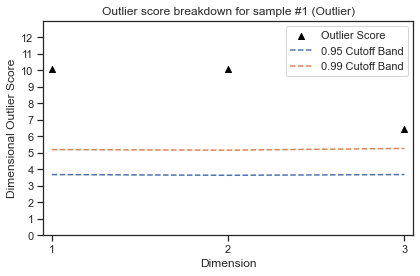

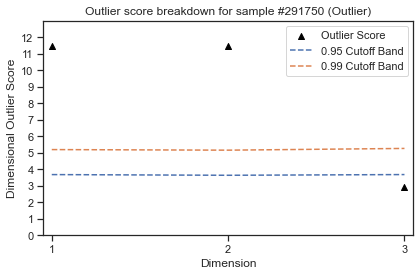

In [472]:
#plot the outliers
ecod_freq.explain_outlier(0)
ecod_freq.explain_outlier(291749)


The univariate outlier scores in observation #1 exceed the 99% cutoff band whereas the outlier scores in observation #291749 has less outlier score exceeds 95% band.

#### Upper Confidence Interval Feature
It has 380,951 normal observations and 20,029 outliers which the outliers are determined by threshold 9.04.

In [473]:
# feature_upper data
ecod_upper = ECOD(contamination=0.05)
ecod_upper.fit(feature_upper)
upper_scores = ecod_upper.decision_function(feature_upper)
upper_pred = ecod_upper.predict(feature_upper)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The feature of upper confidence interval data:", count_stat(upper_pred))

# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , ecod_upper.threshold_)

The feature of upper confidence interval data: {0: 380951, 1: 20029}
The threshold for the defined comtanimation rate: 9.044149550239993


In [474]:
#retrieve the index of outliers
np.where(upper_scores>9.04)

(array([     0,      1,      5, ..., 400726, 400945, 400946], dtype=int64),)

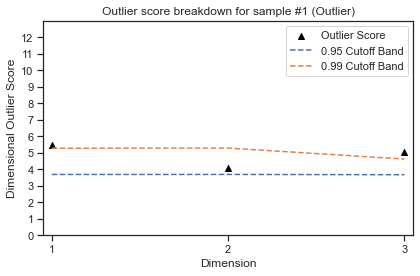

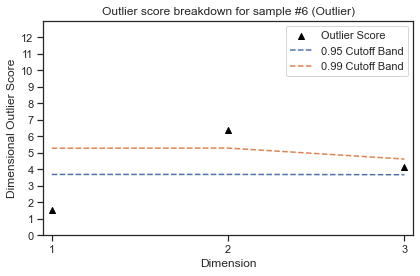

In [475]:
#plot the outliers
ecod_upper.explain_outlier(0)
ecod_upper.explain_outlier(5)

All univariate outlier scores in observation #1 exceed the 95% cutoff band where 2 of the observations are greater than 99% cutoff band. However, the outlier scores in observation #6 has less outlier score exceeds 95% band.

### Step 2: Setting up a reasonble benchmark

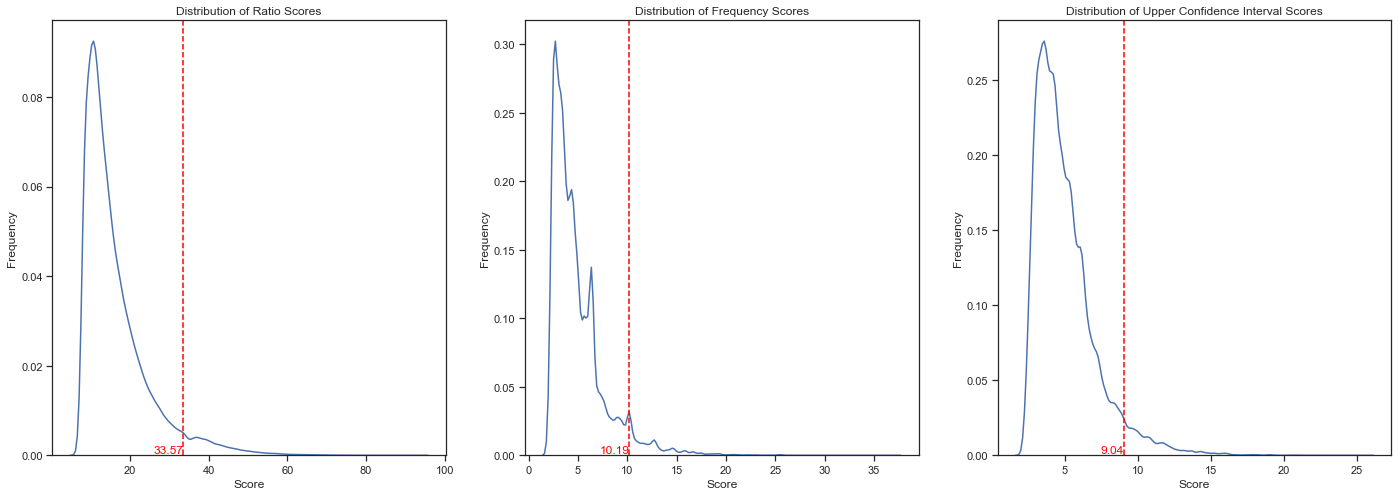

In [482]:
# Plot the distribution
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

sns.kdeplot(ratio_scores, ax=ax1)
ax1.set_title("Distribution of Ratio Scores")
ax1.set_xlabel("Score")
ax1.set_ylabel("Frequency")
ax1.axvline(x=33.57, color='red', linestyle='--')
ax1.text(33.57, 0, "33.57", ha='right', va='bottom', color='red')

sns.kdeplot(freq_scores, ax=ax2)
ax2.set_title("Distribution of Frequency Scores")
ax2.set_xlabel("Score")
ax2.set_ylabel("Frequency")
ax2.axvline(x=10.19, color='red', linestyle='--')
ax2.text(10.19, 0, "10.19", ha='right', va='bottom', color='red')

sns.kdeplot(upper_scores, ax=ax3)
ax3.set_title("Distribution of Upper Confidence Interval Scores")
ax3.set_xlabel("Score")
ax3.set_ylabel("Frequency")
ax3.axvline(x=9.04, color='red', linestyle='--')
ax3.text(9.04, 0, "9.04", ha='right', va='bottom', color='red')

plt.show()

Overall, the distributions of anomaly scores among ratio, frequency, and upper confidence interval features present right skewed distribution with long right tail. The benchmarks of feature scores from the left to the right are 33.57, 10.19, and 9.04. The scores that greater than the benchmark are determined as outliers.

### Step 3: Present the summary statistics of the normal and the abnormal groups
1. The size of the outlier group
2. The average anomaly score
3. The feature statistics in each group

In [512]:
#feature ratio
threshold = ecod_ratio.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_ratio, ratio_scores, threshold)


,Group,Count,Count %,agency_merchant_avg_ratio_amount,agency_merchant_month_avg_ratio_amount,agency_merchant_week_avg_ratio_amount,agency_merchant_vendor_avg_ratio_amount,all_trans_month_avg_ratio_amount,all_trans_mon12_avg_ratio_amount,agency_merchant_median_ratio_amount,agency_merchant_mon_median_ratio_amount,agency_merchant_week_median_ratio_amount,agency_merchant_vendor_median_ratio_amount,Anomaly_Score
0,Normal,420335,94.999977,0.85,0.88,9.299779e+11,0.93,0.96,2.297715e+11,2.03,1.82,1.73,0.93,14.97
1,Outlier,22123,5.000023,3.79,3.26,-1.766950e+13,2.22,1.82,-4.365637e+12,60.51,65.59,34.75,2.22,42.10


The outliers of ratio feature occupy nearly 5% of the dataset with significantly high anomaly score 42.1, which indicates that a data point or observation within a dataset deviates greatly from the expected or normal pattern.

In [478]:
#feature frequency
threshold = ecod_freq.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_freq, freq_scores, threshold)


,Group,Count,Count %,freq1,freq2,freq3,Anomaly_Score
0,Normal,275752,94.51589,0.19,0.19,0.25,4.45
1,Outlier,16000,5.48411,0.37,0.38,0.41,12.79


The outliers occupy nearly 5.5% of the dataset with anomaly score 12.8, which shows that the observations here are highly unusual or abnormal compared to the rest of the dataset.

In [479]:
#feature upper
threshold = ecod_upper.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_upper, upper_scores, threshold)

,Group,Count,Count %,mon_tran_upper,week_tran_upper,recency_upper,Anomaly_Score
0,Normal,380918,94.996758,1362.42,1135.48,9.35,4.72
1,Outlier,20062,5.003242,13255.68,11995.98,28.51,11.13


The outliers of upper confidence interval feature occupy 5% of the dataset with anomaly score 11, which also shows that the observations deviate from the expected behaviour or the pattern established by the majority of the data points.

### Comparison between HBOS and ECOD

HBOS and ECOD share a few similar characteristics. Firstly, they are unsupervised machine learning methods. Second, they assumed the independence of variable to obtain the distribution of a variable. Third, Both are distribution-based so their modeling techniques are faster than others. However, they are still different from each other. For example, HBOS is histogram of a variable but ECOD is cumulative distribution of a variable.

In [531]:
threshold_df = pd.DataFrame({
    'Feature': ['Ratio', 'Frequency', 'Upper Confidence Interval'],
    'HBOS Threshold': [hbos_r.threshold_, hbos_f.threshold_, hbos_u.threshold_],
    'ECOD Threshold': [ecod_ratio.threshold_, ecod_freq.threshold_, ecod_upper.threshold_]
})

print(threshold_df)


                     Feature  HBOS Threshold  ECOD Threshold
0                      Ratio       33.203632       33.567776
1                  Frequency        6.423011       10.194383
2  Upper Confidence Interval        9.956317        9.044150


ECOD method has higher benchmark when detects ratio and frequency features, which means there are less observations are greater than ECOD threshold, representing less outliers compared to HBOS threshold. Whereas under the upper confidence interval feature HBOS has a slightly higher benchmark than ECOD's. 

## Business Insights
Anomalies discovered in the dataset may suggest cases of credit card fraud. Businesses can take proactive measures to avoid fraudulent activity by spotting these abnormalities, such as restricting suspected transactions, contacting cardholders for verification, or strengthening security measures. Although there might incur administratino costs, the costs are still significantly lower than the costs by not being able to detect fraudulent activities from happening. Businesses can find areas for process improvement by studying these abnormalities, such as improving transaction monitoring models and strengthening controls.